## Seattle Air BnB Analysis

### Business Understanding

For this project I'm going to use the Seattle Air BnB Datasets from https://github.com/billyhansen6/SeattleAirBnB.git. Datasets which "describe the listing activity of homestays in Seattle, WA." I'd like to create a model that predicts the price of a listing, and also answer the following questions:

- At what time of year are the listings most expensive? When are they least expensive?
- What property types are the most and least expensive?
- What kinds of hosts generally receive good reviews? What about bad reviews?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import os

### Data Understanding

In [ ]:
os.chdir(r'C:\Users\Billy Hansen\Desktop\Kaggle Practice\Seattle Air BnB') # Enter Working Directory
# Load Data
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')

In [6]:
# Look at calendar data
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
calendar.date.min()

'2016-01-04'

In [8]:
calendar.date.max()

'2017-01-02'

The dataset describes just about one full year of data.

In [9]:
calendar.isnull().sum() # Check null counts

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [10]:
calendar.isnull().mean() # Check null means

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

In [11]:
# Are there any null values for price when the listing is available?
calendar[calendar['available'] == 't'].isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [12]:
# How many unique listings?
print('There are a total of {} unique listings.'.format(len(calendar.listing_id.unique())))

There are a total of 3818 unique listings.


In [13]:
# Does each listing have data for every day in the dataset?
check = calendar.groupby(['listing_id'])['date'].count().reset_index()
print(len(check))
check.head()

3818


,listing_id,date
0,3335,365
1,4291,365
2,5682,365
3,6606,365
4,7369,365


In [14]:
print('Incomplete data on {} listings.'.format(len(check[check['date'] != 365])))

Incomplete data on 0 listings.


In [15]:
# Look at listings data
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [16]:
# Does length of listings match length of unique listings from calendar dataframe?
print(listings.shape)
len(listings) == len(check)

(3818, 92)


True

In [17]:
# Looking at null values
print('{} columns have missing values.'.format(listings[listings.columns[listings.isnull().any()]].shape[1]))
print('{} columns have more that 25% of the data missing.'.format(listings[listings.columns[listings.isnull().mean() > .25]].shape[1]))
print('{} columns have more that 50% of the data missing.'.format(listings[listings.columns[listings.isnull().mean() > .50]].shape[1]))
print('{} columns have more that 75% of the data missing.'.format(listings[listings.columns[listings.isnull().mean() > .75]].shape[1]))
print('{} columns have no data.'.format(listings[listings.columns[listings.isnull().mean() == 1]].shape[1]))

45 columns have missing values.
8 columns have more that 25% of the data missing.
4 columns have more that 50% of the data missing.
2 columns have more that 75% of the data missing.
1 columns have no data.


### Data Preparation

In [18]:
# For the sake of time, I'm going to select the columns that pass the eye test for being potentially relevant.
listings = listings[['id', 'host_id', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'square_feet', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'requires_license', 'license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month']]

In [19]:
# Square Feet
listings.square_feet.describe()

count      97.000000
mean      854.618557
std       671.404893
min         0.000000
25%       420.000000
50%       750.000000
75%      1200.000000
max      3000.000000
Name: square_feet, dtype: float64

In [20]:
listings.square_feet.isnull().mean()

0.9745940282870613

In [21]:
# Too many nulls to be useful. I'll create an isnull column to see if that might be useful
listings['listings_sf_null'] = listings.square_feet.notnull().astype('int')

In [22]:
listings['listings_sf_null'].mean() + listings.square_feet.isnull().mean() # looks good. Drop old column

1.0

In [23]:
listings = listings.drop(columns = ['square_feet'])

In [24]:
# City
listings.city.isnull().mean()

0.0

In [25]:
listings.city.unique()

array(['Seattle', 'Ballard, Seattle', 'West Seattle', 'Seattle ', '西雅图',
       'Phinney Ridge Seattle', 'seattle'], dtype=object)

In [26]:
listings.city.value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
西雅图                         1
seattle                     1
Phinney Ridge Seattle       1
Ballard, Seattle            1
Name: city, dtype: int64

In [27]:
# I don't think this column helps much either. I'll drop it
listings = listings.drop(columns = ['city'])

In [28]:
listings.state.unique()

array(['WA', 'wa'], dtype=object)

In [29]:
listings = listings.drop(columns = ['state']) # drop state column too

In [30]:
# Listing descriptions

In [31]:
listings.space.head(10)

0    Make your self at home in this charming one-be...
1    Beautiful, hypoallergenic apartment in an extr...
2    Our house is modern, light and fresh with a wa...
3                                                  NaN
4    Cozy family craftman house in beautiful neighb...
5    If you include a bit of your background in you...
6    Enjoy a quiet stay in our comfortable 1915 Cra...
7     This cabin was built with Airbnb in mind, Que...
8    Located in the heart of the city, this space i...
9    What's special about this place? A beautiful r...
Name: space, dtype: object

In [32]:
listings.summary.head(10)

0                                                  NaN
1    Chemically sensitive? We've removed the irrita...
2    New modern house built in 2013.  Spectacular s...
3    A charming apartment that sits atop Queen Anne...
4    Cozy family craftman house in beautiful neighb...
5    We're renting out a small private unit of one ...
6    Enjoy a quiet stay in our comfortable 1915 Cra...
7    Our tiny cabin is private , very quiet and com...
8    Nestled in the heart of the city, this space i...
9    Beautiful apartment in an extremely safe, quie...
Name: summary, dtype: object

In [33]:
listings.description.head(10)

0    Make your self at home in this charming one-be...
1    Chemically sensitive? We've removed the irrita...
2    New modern house built in 2013.  Spectacular s...
3    A charming apartment that sits atop Queen Anne...
4    Cozy family craftman house in beautiful neighb...
5    We're renting out a small private unit of one ...
6    Enjoy a quiet stay in our comfortable 1915 Cra...
7    Our tiny cabin is private , very quiet and com...
8    Nestled in the heart of the city, this space i...
9    Beautiful apartment in an extremely safe, quie...
Name: description, dtype: object

In [34]:
# looks like the description column might be most complete, and contains duplicates of the other columns.
listings[['space', 'summary', 'description']].isnull().mean()

space          0.149031
summary        0.046359
description    0.000000
dtype: float64

In [35]:
# I'll only keep the description column and maybe try to extract something useful from it
listings = listings.drop(columns = ['space', 'summary'])

In [36]:
# Experiences offered
listings['experiences_offered'].unique()

array(['none'], dtype=object)

In [37]:
# Drop experiences offered
listings = listings.drop(columns = ['experiences_offered'])

In [38]:
listings['neighborhood_overview'].head()

0                                                  NaN
1    Queen Anne is a wonderful, truly functional vi...
2    Upper Queen Anne is a charming neighborhood fu...
3                                                  NaN
4    We are in the beautiful neighborhood of Queen ...
Name: neighborhood_overview, dtype: object

In [39]:
listings['neighborhood_overview'].isnull().mean()

0.27029858564693554

In [40]:
# Notes
print(listings.notes.isnull().mean())
listings['notes'].head()

0.42063907805133577


0                                                  NaN
1    What's up with the free pillows?  Our home was...
2    Our house is located just 5 short blocks to To...
3                                                  NaN
4                                            Belltown 
Name: notes, dtype: object

In [41]:
# Create Binary "Is Notes" column to see if listing has notes attached to it.
def notes(row):
    if pd.isnull(row['notes']):
        return 0
    else:
        return 1
    
listings['notes'] = listings.apply(notes, axis = 1)

In [42]:
# transit
print(listings.transit.isnull().mean())
listings['transit'].head()

0.24463069669984286


0                                                  NaN
1    Convenient bus stops are just down the block, ...
2    A bus stop is just 2 blocks away.   Easy bus a...
3                                                  NaN
4    The nearest public transit bus (D Line) is 2 b...
Name: transit, dtype: object

In [43]:
# Create Binary "Is Transit" column
def transit(row):
    if pd.isnull(row['transit']):
        return 0
    else:
        return 1
    
listings['transit'] = listings.apply(transit, axis = 1)

In [44]:
# Host Since
print(listings['host_since'].isnull().mean())
listings['host_since'].head()

0.0005238344683080147


0    2011-08-11
1    2013-02-21
2    2014-06-12
3    2013-11-06
4    2011-11-29
Name: host_since, dtype: object

In [45]:
# Create time as host column
import datetime as dt
listings['host_since'] = pd.to_datetime(listings['host_since'])
listings['host_tenure'] = listings['host_since'].apply(lambda x: (dt.datetime.today() - x).days)
# Fill NAs with mean
listings['host_tenure'] = listings['host_tenure'].fillna(listings['host_tenure'].mean())
# Drop Old Column
listings = listings.drop(columns = ['host_since'])

In [46]:
# Host location
listings['host_location'].head()

0    Seattle, Washington, United States
1    Seattle, Washington, United States
2    Seattle, Washington, United States
3    Seattle, Washington, United States
4    Seattle, Washington, United States
Name: host_location, dtype: object

In [47]:
listings['host_location'].unique()[0:10]

array(['Seattle, Washington, United States',
       'Kirkland, Washington, United States',
       'Quilcene, Washington, United States', 'US', nan,
       'Lowell, Massachusetts, United States',
       'Sammamish, Washington, United States',
       'Los Angeles, California, United States',
       'Shoreline, Washington, United States',
       'Portland, Oregon, United States'], dtype=object)

In [48]:
# I'll create a binary "In Seattle" column
listings['Host_Seattle'] = listings['host_location'].apply(lambda x: 1 if 'Seattle' in str(x) else 0)
# Drop old column
listings = listings.drop(columns = ['host_location'])

In [49]:
listings['host_about'].head()

0    I am an artist, interior designer, and run a s...
1    Living east coast/left coast/overseas.  Time i...
2    i love living in Seattle.  i grew up in the mi...
3                                                  NaN
4    Hi, I live in Seattle, Washington but I'm orig...
Name: host_about, dtype: object

In [50]:
# Create "Has About" column
listings['host_has_about'] = listings['host_about'].apply(lambda x: 0 if pd.isnull(x) else 1)
# Drop old column
listings = listings.drop(columns = ['host_about'])

In [51]:
# Host Response Time
listings.host_response_time.head()

0    within a few hours
1        within an hour
2    within a few hours
3                   NaN
4        within an hour
Name: host_response_time, dtype: object

In [52]:
listings.host_response_time.unique()
# We'll create dummies later for this column

array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

In [53]:
listings['host_acceptance_rate'].head(10)

0    100%
1    100%
2    100%
3     NaN
4     NaN
5     NaN
6    100%
7    100%
8    100%
9    100%
Name: host_acceptance_rate, dtype: object

In [54]:
listings['host_acceptance_rate'].isnull().mean()

0.20246202200104768

In [55]:
listings['host_acceptance_rate'].value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

In [56]:
# Will Create Is 100 or not
listings['Acceptance_100'] = listings['host_acceptance_rate'].apply(lambda x: 1 if x == '100%' else 0)
# Drop old column
listings = listings.drop(columns = ['host_acceptance_rate'])

In [57]:
# Super host
listings['host_is_superhost'].head(10)

0    f
1    t
2    f
3    f
4    f
5    f
6    t
7    t
8    f
9    t
Name: host_is_superhost, dtype: object

In [58]:
listings['host_is_superhost'].unique()

array(['f', 't', nan], dtype=object)

In [59]:
# replace nulls with false - i assume null means they are not a superhost
listings['host_is_superhost'] = listings['host_is_superhost'].fillna('f')

In [60]:
# Host listings count
listings['host_listings_count'].head()

0    3.0
1    6.0
2    2.0
3    1.0
4    2.0
Name: host_listings_count, dtype: float64

In [61]:
listings['host_listings_count'].isnull().mean()

0.0005238344683080147

In [62]:
listings['host_listings_count'].describe()

count    3816.000000
mean        7.157757
std        28.628149
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       502.000000
Name: host_listings_count, dtype: float64

In [63]:
# Replace nulls with median of 1
listings['host_listings_count'] = listings['host_listings_count'].fillna(1)

In [64]:
# Bin to help with outliers
def list_bins(row):
    if row['host_listings_count'] == 1:
        return '1 Listing'
    elif row['host_listings_count'] < 6:
        return '2-5 Listings'
    elif row['host_listings_count'] < 16:
        return '6-15 Listings'
    else:
        return 'Greater than 15 listings'
    
    
listings['host_listings_count'] = listings.apply(list_bins, axis = 1)

In [65]:
listings['host_listings_count'].value_counts()

1 Listing                   2181
2-5 Listings                1130
Greater than 15 listings     303
6-15 Listings                204
Name: host_listings_count, dtype: int64

In [66]:
# Host Has Profile Pic
listings['host_has_profile_pic'].head()

0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object

In [67]:
listings['host_has_profile_pic'].isnull().mean()

0.0005238344683080147

In [68]:
listings['host_has_profile_pic'].value_counts()

t    3809
f       7
Name: host_has_profile_pic, dtype: int64

In [69]:
# Will dummy these, preserving null data

In [70]:
# Host Identity Varified
listings['host_identity_verified'].value_counts()

t    2997
f     819
Name: host_identity_verified, dtype: int64

In [71]:
# Host Street
listings['street'].head(10)

0        Gilman Dr W, Seattle, WA 98119, United States
1    7th Avenue West, Seattle, WA 98119, United States
2    West Lee Street, Seattle, WA 98119, United States
3    8th Avenue West, Seattle, WA 98119, United States
4         14th Ave W, Seattle, WA 98119, United States
5    West Comstock Street, Seattle, WA 98119, Unite...
6    10th Avenue West, Seattle, WA 98119, United St...
7    West Wheeler Street, Seattle, WA 98119, United...
8    Queen Anne Avenue North, Seattle, WA 98109, Un...
9    7th Avenue West, Seattle, WA 98119, United States
Name: street, dtype: object

In [72]:
listings['street'].isnull().mean()

0.0

In [73]:
# Drop street
listings = listings.drop(columns = ['street'])

In [74]:
# neighbourhood
listings['neighbourhood'].sample(10)

175                       Ballard
1326                     Belltown
3127          University District
1695    Central Business District
3742                      Fremont
821         Harrison/Denny-Blaine
2070            North Beacon Hill
2338                  Seward Park
2904                          NaN
3325               Licton Springs
Name: neighbourhood, dtype: object

In [75]:
# neighbourhood
len(listings['neighbourhood'].unique())

82

In [76]:
# Maybe dummy, maybe drop neighborhood

In [77]:
# neighbourhood_cleansed
listings['neighbourhood_cleansed'].sample(10)

198        West Woodland
2754            Broadway
2005           Greenwood
3174    Lower Queen Anne
3199    Lower Queen Anne
3320           Pinehurst
176        West Woodland
3462          High Point
1799       North Admiral
2052          Holly Park
Name: neighbourhood_cleansed, dtype: object

In [78]:
len(listings['neighbourhood_cleansed'].unique())

87

In [79]:
# Drop regular neighborhood column and keep clean one
listings = listings.drop(columns = ['neighbourhood'])

In [80]:
# neighbourhood_group_cleansed
listings['neighbourhood_group_cleansed'].sample(10)

328     Other neighborhoods
1774           West Seattle
1379               Downtown
520     Other neighborhoods
2511               Delridge
1114                Cascade
1473               Downtown
918            Central Area
3220             Queen Anne
1106                Cascade
Name: neighbourhood_group_cleansed, dtype: object

In [81]:
len(listings['neighbourhood_group_cleansed'].unique())

17

In [82]:
# Should use neighborhood group for sure. I don't want to overwhelm the model with too many dummy columns.
listings = listings.drop(columns = ['neighbourhood_cleansed'])

In [83]:
# Zip code
listings['zipcode'].sample(10)

3339    98103
2886    98102
2049    98103
585     98122
3464    98106
2185    98118
1736    98116
2616    98122
1909    98116
738     98105
Name: zipcode, dtype: object

In [84]:
len(listings.zipcode.unique())

29

In [85]:
# Drop, I think neighborhood group will capture this
listings = listings.drop(columns = ['zipcode'])

In [86]:
# Market
listings['market'].sample(10)

3650    Seattle
1949    Seattle
2638    Seattle
2929    Seattle
2293    Seattle
2486    Seattle
2384    Seattle
3250    Seattle
2849    Seattle
2757    Seattle
Name: market, dtype: object

In [87]:
listings['market'].value_counts()

Seattle    3818
Name: market, dtype: int64

In [88]:
# Drop
listings = listings.drop(columns = ['market'])

In [89]:
# smart_location
listings['smart_location'].head()

0    Seattle, WA
1    Seattle, WA
2    Seattle, WA
3    Seattle, WA
4    Seattle, WA
Name: smart_location, dtype: object

In [90]:
listings['smart_location'].unique()

array(['Seattle, WA', 'Ballard, Seattle, WA', 'West Seattle, WA',
       'Seattle , WA', '西雅图, WA', 'Phinney Ridge Seattle, WA',
       'seattle, wa'], dtype=object)

In [91]:
# Drop
listings = listings.drop(columns = ['smart_location'])

In [92]:
# Is location exact - drop
listings = listings.drop(columns = ['is_location_exact'])

In [93]:
# Property Type
listings['property_type'].head()

0    Apartment
1    Apartment
2        House
3    Apartment
4        House
Name: property_type, dtype: object

In [94]:
listings['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [95]:
# Will dummy property type for modelling

In [96]:
''' property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'amenities' will all surely be useful'''

" property_type', 'room_type', 'accommodates', 'bathrooms',\n       'bedrooms', 'beds', 'bed_type', 'amenities' will all surely be useful"

In [97]:
listings['weekly_price'].head()

0          NaN
1    $1,000.00
2          NaN
3      $650.00
4          NaN
Name: weekly_price, dtype: object

In [98]:
listings['weekly_price'].isnull().mean()

0.4738082765845993

In [99]:
listings['monthly_price'].isnull().mean()

0.6026715557883708

In [100]:
# I think I'll drop these, and use the calendar dateset to calculate these values
listings = listings.drop(columns = ['weekly_price', 'monthly_price'])

In [101]:
# Security deposit
listings['security_deposit'].head(10)

0          NaN
1      $100.00
2    $1,000.00
3          NaN
4      $700.00
5          NaN
6      $150.00
7      $150.00
8          NaN
9      $100.00
Name: security_deposit, dtype: object

In [102]:
len(listings[listings['security_deposit'] == 0])

0

In [103]:
3 # I assume that nulls represent no security deposit
listings['security_deposit'] = listings['security_deposit'].fillna(0)

In [104]:
# Cleaning fee
print(len(listings[listings['cleaning_fee'] == 0]))
listings['cleaning_fee'].head(10)

0


0        NaN
1     $40.00
2    $300.00
3        NaN
4    $125.00
5     $40.00
6        NaN
7     $25.00
8        NaN
9     $40.00
Name: cleaning_fee, dtype: object

In [105]:
# Here too, I assume null cleaning fees mean $0
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)

In [106]:
# Guests included
listings['guests_included'].head()

0     2
1     1
2    10
3     1
4     6
Name: guests_included, dtype: int64

In [107]:
listings['guests_included'].describe()

count    3818.000000
mean        1.672603
std         1.311040
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        15.000000
Name: guests_included, dtype: float64

In [108]:
listings['guests_included'].isnull().sum()

0

In [109]:
# Extra people
listings['extra_people'].head()

0     $5.00
1     $0.00
2    $25.00
3     $0.00
4    $15.00
Name: extra_people, dtype: object

In [110]:
listings['extra_people'].describe()

count      3818
unique       45
top       $0.00
freq       2048
Name: extra_people, dtype: object

In [111]:
# I'll rename this to something more intuitive and bin them into groups.
listings['extra_people_fee'] = listings['extra_people'].apply(lambda x: x.split('.')[0].replace('$', '')).astype('int')

In [112]:
listings['extra_people_fee'].describe()

count    3818.000000
mean       10.667627
std        17.585922
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max       300.000000
Name: extra_people_fee, dtype: float64

In [113]:
# drop origional and bin into new column
listings = listings.drop(columns = ['extra_people'])

In [114]:
def extra_people(row):
    if row['extra_people_fee'] == 0:
        return 'No Fee'
    elif row['extra_people_fee'] < 21:
        return '$1 - $20'
    elif row['extra_people_fee'] < 51:
        return '$21 - $50'
    else:
        return 'Greater than $50'

listings['extra_people_fee'] = listings.apply(extra_people, axis = 1)

In [115]:
listings['extra_people_fee'].value_counts()

No Fee              2048
$1 - $20            1090
$21 - $50            627
Greater than $50      53
Name: extra_people_fee, dtype: int64

In [116]:
# Minium nights
listings.minimum_nights.describe()

count    3818.000000
mean        2.369303
std        16.305902
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max      1000.000000
Name: minimum_nights, dtype: float64

In [117]:
listings.minimum_nights.isnull().sum()

0

In [118]:
# I'll bin these as well

def min_nights(row):
    if row['minimum_nights'] < 3:
        return 'Less than 3 nights'
    elif row['minimum_nights'] < 11:
        return '3 - 10 nights'
    elif row['minimum_nights'] < 31:
        return '11 - 30 nights'
    else:
        return 'Greater than 30 nights'
    
listings['minimum_nights'] = listings.apply(min_nights, axis=1)

In [119]:
# Mex nights
listings['maximum_nights'].describe()

count      3818.000000
mean        780.447617
std        1683.589007
min           1.000000
25%          60.000000
50%        1125.000000
75%        1125.000000
max      100000.000000
Name: maximum_nights, dtype: float64

In [120]:
listings['maximum_nights'].mode()

0    1125
dtype: int64

In [121]:
# Binary. is max nights less than 5 or not
listings['maximum_nights'] = listings['maximum_nights'].apply(lambda x: 1 if x < 5 else 0)

In [122]:
listings['maximum_nights'].value_counts()

0    3752
1      66
Name: maximum_nights, dtype: int64

In [123]:
listings.columns.values

array(['id', 'host_id', 'description', 'neighborhood_overview', 'notes',
       'transit', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'license',
       'jurisdiction_names', 'insta

In [124]:
listings = listings.drop(columns = ['calendar_updated', 'has_availability', 'calendar_last_scraped'])

In [125]:
listings.availability_30.describe()

count    3818.000000
mean       16.786276
std        12.173637
min         0.000000
25%         2.000000
50%        20.000000
75%        30.000000
max        30.000000
Name: availability_30, dtype: float64

In [126]:
listings.availability_60.describe()

count    3818.000000
mean       36.814825
std        23.337541
min         0.000000
25%        13.000000
50%        46.000000
75%        59.000000
max        60.000000
Name: availability_60, dtype: float64

In [127]:
listings.availability_90.describe()

count    3818.000000
mean       58.082504
std        34.063845
min         0.000000
25%        28.000000
50%        73.000000
75%        89.000000
max        90.000000
Name: availability_90, dtype: float64

In [128]:
listings.availability_365.describe()

count    3818.000000
mean      244.772656
std       126.772526
min         0.000000
25%       124.000000
50%       308.000000
75%       360.000000
max       365.000000
Name: availability_365, dtype: float64

In [129]:
# I'll keep all of these availability stats

In [130]:
listings['number_of_reviews'].head()

0    207
1     43
2     20
3      0
4     38
Name: number_of_reviews, dtype: int64

In [131]:
listings['number_of_reviews'].describe()

count    3818.000000
mean       22.223415
std        37.730892
min         0.000000
25%         2.000000
50%         9.000000
75%        26.000000
max       474.000000
Name: number_of_reviews, dtype: float64

In [132]:
listings['number_of_reviews'].isnull().sum()

0

In [133]:
listings['first_review'].head()

0    2011-11-01
1    2013-08-19
2    2014-07-30
3           NaN
4    2012-07-10
Name: first_review, dtype: object

In [134]:
listings['last_review'].head()

0    2016-01-02
1    2015-12-29
2    2015-09-03
3           NaN
4    2015-10-24
Name: last_review, dtype: object

In [135]:
# drop first and last review
listings = listings.drop(columns = ['first_review', 'last_review'])

In [136]:
# Reviews score rating
listings['review_scores_rating'].head()

0    95.0
1    96.0
2    97.0
3     NaN
4    92.0
Name: review_scores_rating, dtype: float64

In [137]:
listings['review_scores_rating'].describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

In [138]:
# I'll bin all of the review scores, preserving records with no reviews.
def rsr(row):
    if pd.isnull(row['review_scores_rating']):
        return 'No Review Score'
    elif row['review_scores_rating'] < 80:
        return 'Review Score Less than 80'
    elif row['review_scores_rating'] < 90:
        return 'Review Score 80-89'
    elif row['review_scores_rating'] < 95:
        return 'Review Score 90-94'
    else:
        return 'Review Score 95 - 100'

listings['review_scores_rating'] = listings.apply(rsr, axis = 1)

In [139]:
listings['review_scores_rating'].value_counts()

Review Score 95 - 100        2023
Review Score 90-94            722
No Review Score               647
Review Score 80-89            356
Review Score Less than 80      70
Name: review_scores_rating, dtype: int64

In [140]:
listings['review_scores_accuracy'].describe()

count    3160.000000
mean        9.636392
std         0.698031
min         2.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_accuracy, dtype: float64

In [141]:
def rsa(row):
    if pd.isnull(row['review_scores_accuracy']):
        return 'No Review Score Accuracy'
    elif row['review_scores_accuracy'] < 10:
        return 'Review Score Accuracy Less than 10'
    else:
        return 'Review Score Accuracy 10'

listings['review_scores_accuracy'] = listings.apply(rsa, axis = 1)

In [142]:
listings['review_scores_accuracy'].value_counts()

Review Score Accuracy 10              2261
Review Score Accuracy Less than 10     899
No Review Score Accuracy               658
Name: review_scores_accuracy, dtype: int64

In [143]:
listings['review_scores_cleanliness'].describe()

count    3165.000000
mean        9.556398
std         0.797274
min         3.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_cleanliness, dtype: float64

In [144]:
def rsc(row):
    if row['review_scores_cleanliness'] == 10:
        return 'Review Score Cleanliness 10'
    elif pd.isnull(row['review_scores_cleanliness']):
        return 'No Review Score Cleanliness'
    elif row['review_scores_cleanliness'] < 7:
        return 'Review Score Cleanliness Less than 7'
    else: 
        return 'Review Score Cleanliness 7 - 10'


listings['review_scores_cleanliness'] = listings.apply(rsc, axis = 1)

In [145]:
listings['review_scores_cleanliness'].value_counts()

Review Score Cleanliness 10             2161
Review Score Cleanliness 7 - 10          964
No Review Score Cleanliness              653
Review Score Cleanliness Less than 7      40
Name: review_scores_cleanliness, dtype: int64

In [146]:
listings['review_scores_checkin'].describe()

count    3160.000000
mean        9.786709
std         0.595499
min         2.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_checkin, dtype: float64

In [147]:
def rsc(row):
    if row['review_scores_checkin'] == 10:
        return 'Review Score Checkin 10'
    elif pd.isnull(row['review_scores_checkin']):
        return 'No Review Score Checkin'
    elif row['review_scores_checkin'] < 7:
        return 'Review Score Checkin Less than 7'
    else: 
        return 'Review Score CheckIn 7 - 10'


listings['review_scores_checkin'] = listings.apply(rsc, axis = 1)

In [148]:
listings['review_scores_checkin'].value_counts()

Review Score Checkin 10             2644
No Review Score Checkin              658
Review Score CheckIn 7 - 10          499
Review Score Checkin Less than 7      17
Name: review_scores_checkin, dtype: int64

In [149]:
listings['review_scores_communication'].describe()

count    3167.000000
mean        9.809599
std         0.568211
min         2.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_communication, dtype: float64

In [150]:
def rsc(row):
    if row['review_scores_communication'] == 10:
        return 'Review Score Communication 10'
    elif pd.isnull(row['review_scores_communication']):
        return 'No Review Score Communication'
    elif row['review_scores_communication'] < 7:
        return 'Review Score Communication Less than 7'
    else: 
        return 'Review Score Communication 7 - 10'


listings['review_scores_communication'] = listings.apply(rsc, axis = 1)

In [151]:
listings['review_scores_communication'].value_counts()

Review Score Communication 10             2700
No Review Score Communication              651
Review Score Communication 7 - 10          452
Review Score Communication Less than 7      15
Name: review_scores_communication, dtype: int64

In [152]:
# I'll drop the rest for the sake of my mental health
listings = listings.drop(columns= ['review_scores_location', 'review_scores_value'])

In [153]:
listings['requires_license'].value_counts()

f    3818
Name: requires_license, dtype: int64

In [154]:
listings.license.value_counts()

Series([], Name: license, dtype: int64)

In [155]:
listings['jurisdiction_names'].value_counts()

WASHINGTON    3818
Name: jurisdiction_names, dtype: int64

In [156]:
# Drop all of these above
listings = listings.drop(columns = ['jurisdiction_names', 'license', 'requires_license'])

In [157]:
listings['instant_bookable'].value_counts()

f    3227
t     591
Name: instant_bookable, dtype: int64

In [158]:
listings['instant_bookable'].isnull().sum()

0

In [159]:
listings['cancellation_policy'].value_counts()

strict      1417
moderate    1251
flexible    1150
Name: cancellation_policy, dtype: int64

In [160]:
listings['cancellation_policy'].isnull().sum()

0

In [161]:
listings['require_guest_profile_picture'].value_counts()

f    3497
t     321
Name: require_guest_profile_picture, dtype: int64

In [162]:
listings['require_guest_phone_verification'].value_counts()

f    3443
t     375
Name: require_guest_phone_verification, dtype: int64

In [163]:
listings['calculated_host_listings_count'].describe()

count    3818.000000
mean        2.946307
std         5.893029
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        37.000000
Name: calculated_host_listings_count, dtype: float64

In [164]:
listings['calculated_host_listings_count'].isnull().sum()

0

In [165]:
listings['reviews_per_month'].describe()

count    3191.000000
mean        2.078919
std         1.822348
min         0.020000
25%         0.695000
50%         1.540000
75%         3.000000
max        12.150000
Name: reviews_per_month, dtype: float64

In [166]:
listings['reviews_per_month'].isnull().sum()

627

In [167]:
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)

In [168]:
listings['neighborhood_overview'].head()

0                                                  NaN
1    Queen Anne is a wonderful, truly functional vi...
2    Upper Queen Anne is a charming neighborhood fu...
3                                                  NaN
4    We are in the beautiful neighborhood of Queen ...
Name: neighborhood_overview, dtype: object

In [169]:
# For neighborhood overview, I'll create a binary "IsNull" column
listings['neighborhood_overview'] = listings['neighborhood_overview'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [170]:
listings['neighborhood_overview'].head()

0    0
1    1
2    1
3    0
4    1
Name: neighborhood_overview, dtype: int64

In [171]:
listings['host_response_time'].head()

0    within a few hours
1        within an hour
2    within a few hours
3                   NaN
4        within an hour
Name: host_response_time, dtype: object

In [172]:
# I'll replace nulls with "No Data"
listings['host_response_time'] = listings['host_response_time'].apply(lambda x: "No Data" if pd.isnull(x) else x)

In [173]:
listings['host_response_time'].isnull().sum()

0

In [174]:
# host response rate - I'll create bins
listings['host_response_rate'] = listings['host_response_rate'].fillna('0%')
listings['host_response_rate'] = listings.host_response_rate.apply(lambda x: int(str(x).replace('%', '')))

In [175]:
listings['host_response_rate'].describe()

count    3818.000000
mean       81.888947
std        34.441009
min         0.000000
25%        88.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

In [176]:
def rr(row):
    if row['host_response_rate'] == 0:
        return 'No Data'
    elif row['host_response_rate'] < 88:
        return '0 - 88'
    elif row['host_response_rate'] < 100:
        return '88 - 99'
    else:
        return '100'
    
listings['host_response_rate'] = listings.apply(rr, axis = 1)

In [177]:
listings['host_response_rate'].value_counts()

100        2371
No Data     523
88 - 99     513
0 - 88      411
Name: host_response_rate, dtype: int64

In [178]:
listings[listings.columns[listings.isnull().mean() > .0]].columns


Index(['host_has_profile_pic', 'host_identity_verified', 'property_type',
       'bathrooms', 'bedrooms', 'beds'],
      dtype='object')

In [179]:
listings.host_has_profile_pic.value_counts()

t    3809
f       7
Name: host_has_profile_pic, dtype: int64

In [180]:
listings.host_has_profile_pic = listings.host_has_profile_pic.fillna('No Data')

In [181]:
listings.host_identity_verified.value_counts()

t    2997
f     819
Name: host_identity_verified, dtype: int64

In [182]:
listings.host_identity_verified = listings.host_identity_verified.fillna('No Data')

In [183]:
listings.property_type.isnull().sum()

1

In [184]:
listings.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [185]:
listings.property_type = listings.property_type.fillna('No Data')

In [186]:
listings.bathrooms.describe()

count    3802.000000
mean        1.259469
std         0.590369
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: bathrooms, dtype: float64

In [187]:
# Fill bathroom NAs with 0
listings.bathrooms = listings.bathrooms.fillna(0)

In [188]:
listings.bedrooms.describe()

count    3812.000000
mean        1.307712
std         0.883395
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: bedrooms, dtype: float64

In [189]:
# Fill bedrooms NAs with 0
listings.bedrooms = listings.bedrooms.fillna(0)

In [190]:
# Fill Bed NAs with 0
listings['beds'] = listings['beds'].fillna(0)

In [191]:
listings[listings.columns[listings.isnull().any()]].columns

Index([], dtype='object')

In [192]:
listings = listings.drop(columns = ['description'])

In [193]:
listings.columns.values

array(['id', 'host_id', 'neighborhood_overview', 'notes', 'transit',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
       'listings_sf_null', 'host_tenure', 'Host_Seat

Now that I have clean-ish data, I want to see how these features relate to the price and availability column. I'll join this dataset to the calendar.

In [194]:
calendar.head(10)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00


In [195]:
len(calendar)

1393570

In [196]:
# Join Data
df = calendar.merge(listings, how = 'inner', left_on = ['listing_id'], right_on = ['id'])

In [197]:
# Make Sure join worked properly
len(df) == len(calendar)

True

In [198]:
len(df[pd.isnull(df['id'])])

0

In [199]:
# Looks Good

In [200]:
df.head()

,listing_id,date,available,price_x,id,host_id,neighborhood_overview,notes,transit,host_response_time,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listings_sf_null,host_tenure,Host_Seattle,host_has_about,Acceptance_100,extra_people_fee
0,241032,2016-01-04,t,$85.00,241032,956883,0,0,0,within a few hours,...,f,f,2,4.07,0,3234.0,1,1,1,$1 - $20
1,241032,2016-01-05,t,$85.00,241032,956883,0,0,0,within a few hours,...,f,f,2,4.07,0,3234.0,1,1,1,$1 - $20
2,241032,2016-01-06,f,NaN,241032,956883,0,0,0,within a few hours,...,f,f,2,4.07,0,3234.0,1,1,1,$1 - $20
3,241032,2016-01-07,f,NaN,241032,956883,0,0,0,within a few hours,...,f,f,2,4.07,0,3234.0,1,1,1,$1 - $20
4,241032,2016-01-08,f,NaN,241032,956883,0,0,0,within a few hours,...,f,f,2,4.07,0,3234.0,1,1,1,$1 - $20


In [201]:
listings.shape

(3818, 48)

In [202]:
len(listings.id.unique())

3818

In [203]:
calendar.date.max()

'2017-01-02'

In [204]:
'''Need to properly label price columns - I assume that the price in the listing dataframe represents the final price
when the data was scrapped. The price in the calendar column will be much more useful then. I'll rename these columns'''
df = df.rename(columns = {'price_x':'price', 'price_y': 'last_price'})

In [205]:
# Make price numeric
df.price = df.price.apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

In [206]:
avg_price = df.groupby(['listing_id'])['price'].mean().reset_index().rename(columns = {'price':'avg. price'})
avg_price.head()

,listing_id,avg. price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000


In [207]:
avg_price.isnull().sum()

listing_id     0
avg. price    95
dtype: int64

In [208]:
# Transform availability column
df['available'] = df['available'].apply(lambda x: 1 if x == 't' else 0)

In [209]:
# why are there nulls on avg. price?
check_lst = list(avg_price[pd.isnull(avg_price['avg. price'])][['listing_id']]['listing_id'])
check_lst[0:5]

[107046, 284813, 445199, 777159, 1030411]

In [210]:
count = []
for i in check_lst:
    if df[df['listing_id'] == i][['price', 'available']].available.sum() > 0:
        count.append(i)
    else:
        pass
count

[]

So there are a number of listings that were not rented all year long. I'll have to decide how to handle these.

In [211]:
print(df[df['listing_id'] == 107046][['price']].sum())
df[df['listing_id'] == 107046][['last_price']].head()

price    0.0
dtype: float64


,last_price
897170,$280.00
897171,$280.00
897172,$280.00
897173,$280.00
897174,$280.00


In [212]:
print(df[df['listing_id'] == 777159][['price']].sum())
df[df['listing_id'] == 777159][['last_price']].head()

price    0.0
dtype: float64


,last_price
832565,$150.00
832566,$150.00
832567,$150.00
832568,$150.00
832569,$150.00


### Answering Business Questions

### When are the prices in Seattle the highest? When are they the lowest?

In [213]:
df.date.min()

'2016-01-04'

In [214]:
df.date.max()

'2017-01-02'

In [215]:
# I'm going to chop off th records from 2017, and only look at 2016 as a whole
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] < '2017-01-01']

In [216]:
df[['date', 'price', 'available']].head()

,date,price,available
0,2016-01-04,85.0,1
1,2016-01-05,85.0,1
2,2016-01-06,NaN,0
3,2016-01-07,NaN,0
4,2016-01-08,NaN,0


In [217]:
# Create copy of dataframe with date as the index
df2 = df.copy()
df2.index = df2['date']

In [218]:
# Plot value counts by month
df2[['price']].resample('m').count()

,price
date,
2016-01-31,59239
2016-02-29,73321
2016-03-31,83938
2016-04-30,76037
2016-05-31,79971
2016-06-30,77244
2016-07-31,74222
2016-08-31,76347
2016-09-30,77246


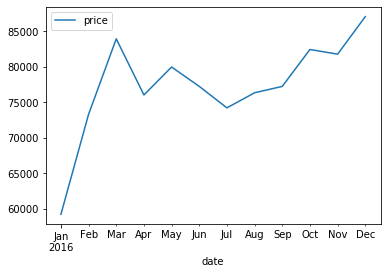

In [219]:
df2[['price']].resample('m').count().plot()

In [220]:
df2[['price']].resample('m').mean()

,price
date,
2016-01-31,121.568409
2016-02-29,124.293927
2016-03-31,128.644488
2016-04-30,135.097005
2016-05-31,139.538183
2016-06-30,147.473137
2016-07-31,152.094150
2016-08-31,150.656594
2016-09-30,143.255949


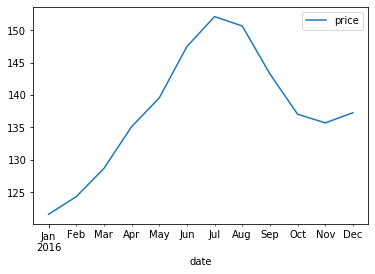

In [221]:
# Plot mean price by month
df2[['price']].resample('m').mean().plot()

In [222]:
df2['price'].mean()

137.95137504252597

In [223]:
### In 2016, the average price was greatest in the summer, with a high of $152 in July. 
### It was lowest in the winter, with a low of $121 per listing in January.
# the average across all listings was about $138 per listing.

### How do the prices vary by property type?

In [224]:
# Average price by property type
df.groupby(['property_type'])['price'].mean().sort_values()

property_type
Dorm                39.383886
Tent                57.563510
Treehouse           64.423019
Chalet              93.478852
Yurt               105.423729
Other              106.436487
Cabin              114.279945
Bed & Breakfast    116.041101
No Data            120.000000
Bungalow           124.203766
Camper/RV          127.017931
Townhouse          132.841266
Loft               133.506865
House              136.611088
Apartment          139.333203
Condominium        169.540366
Boat               330.743034
Name: price, dtype: float64

We can see here that the most expensive propery types are boat, condominium, apartment and house.
The least expensive are dorm, tent and treehouse.

In [225]:
# Most common propety types
listings['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Bungalow             13
Camper/RV            13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
No Data               1
Name: property_type, dtype: int64

In [226]:
# Create month of date column
df['month'] = pd.DatetimeIndex(df['date']).month

In [227]:
# Average price for common property types
df[df['property_type'].isin(['House', 'Apartment', 'Townhouse', 'Condominium'])].groupby(['property_type', 'month'])['price'].mean().sort_values()

property_type  month
House          1        119.421669
Townhouse      1        119.563996
               2        120.408198
House          2        121.592044
Apartment      1        122.334342
Townhouse      3        123.002322
House          3        123.975961
Apartment      2        125.130166
Townhouse      4        126.506679
Apartment      11       130.777340
Townhouse      5        131.533953
House          4        132.145898
Apartment      3        132.285559
               12       132.572962
               10       133.534631
House          5        135.515893
Townhouse      10       135.537964
               11       136.187899
               6        136.441546
               9        137.237736
Apartment      4        137.870782
House          11       139.901386
               10       140.051861
Townhouse      8        140.207875
House          12       141.071231
               6        141.661751
Townhouse      12       142.593499
Apartment      9        142.799941

In [228]:
# A House in January is the least expensive on average.
# Condominiums tend to be more expensive than other units.

### What kind of hosts have good at bad reviews?

In [230]:
listings.review_scores_rating.head()

0    Review Score 95 - 100
1    Review Score 95 - 100
2    Review Score 95 - 100
3          No Review Score
4       Review Score 90-94
Name: review_scores_rating, dtype: object

In [231]:
# I'm going to redownload the raw listings data in order to answer a few questions
df_list = pd.read_csv('listings.csv')

In [233]:
# Create new dataframe with number of listings per host
hosts = df_list.groupby(['host_id'])['id'].count().reset_index().rename(columns = {'id':'listings_counts'})

In [234]:
# Join to relevant dataframes
df_list = df_list.merge(hosts, how = 'inner', on = ['host_id'])
listings = listings.merge(hosts, how = 'inner', on = ['host_id'])
df = df.merge(hosts, how = 'inner', on = ['host_id'])
df2 = df2.merge(hosts, how = 'inner', on = ['host_id'])

In [235]:
# How many unique hosts are there?
print('There are {} unique hosts.'.format(len(hosts)))

There are 2751 unique hosts.


In [236]:
# How many hosts have more than one listing?
len(hosts[hosts['listings_counts'] > 1])

466

In [237]:
# Do hosts with more than one unit have better reviews?
df_list['host_multiple'] = df_list['listings_counts'].apply(lambda x: 'Multiple Listings' if x > 1 else 'One Listing')

In [238]:
# Mean Review Score by if host has multiple units
df_list.groupby(['host_multiple'])['review_scores_rating'].mean()

host_multiple
Multiple Listings    93.611360
One Listing          95.216585
Name: review_scores_rating, dtype: float64

Host who have only one listing tend to be slightly better rated.

In [239]:
# Attach Review scores rating onto main dataframe
rate = df_list[['id', 'review_scores_rating']].rename(columns = {'review_scores_rating': 'review_scores_rating_raw'})
df = df.merge(rate, how = 'inner', left_on = ['listing_id'], right_on = ['id'])
df = df.drop(columns = ['id_y'])
df = df.rename(columns = {'id_x': 'id'})

In [240]:
df.groupby(['Host_Seattle'])['review_scores_rating_raw'].mean()

Host_Seattle
0    93.753316
1    94.645311
Name: review_scores_rating_raw, dtype: float64

No significant difference between hosts in seattle and outside seattle

In [241]:
# Is host response time coorelated with reviews?
df.groupby(['host_response_time'])['review_scores_rating_raw'].mean()

host_response_time
No Data               94.583333
a few days or more    87.793103
within a day          94.264831
within a few hours    93.812425
within an hour        95.143984
Name: review_scores_rating_raw, dtype: float64

The hosts who take a few days to respond have significantly worse scores.

In [242]:
# Is host response rate coorelated with reviews?
df.groupby(['host_response_rate'])['review_scores_rating_raw'].mean()

host_response_rate
0 - 88     91.647929
100        95.277885
88 - 99    93.240363
No Data    94.583333
Name: review_scores_rating_raw, dtype: float64

Hosts with high response rates have better scores

In [244]:
# Do super hosts have better scores?
df.groupby(['host_is_superhost'])['review_scores_rating_raw'].mean()

host_is_superhost
f    93.652893
t    97.395473
Name: review_scores_rating_raw, dtype: float64

They sure do

In [245]:
df.columns.values

array(['listing_id', 'date', 'available', 'price', 'id', 'host_id',
       'neighborhood_overview', 'notes', 'transit', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'last_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
   

### Coorelations

In [246]:
# Let's check some coorelations of interest
df[['price', 'review_scores_rating_raw', 'host_tenure', 'reviews_per_month', 'listings_counts', 'availability_365']].corr()

,price,review_scores_rating_raw,host_tenure,reviews_per_month,listings_counts,availability_365
price,1.000000,0.079324,0.081070,-0.162325,0.129297,-0.008300
review_scores_rating_raw,0.079324,1.000000,-0.033396,0.087313,-0.125735,-0.038600
host_tenure,0.081070,-0.033396,1.000000,-0.052677,0.246368,0.088847
reviews_per_month,-0.162325,0.087313,-0.052677,1.000000,-0.093999,0.034873
listings_counts,0.129297,-0.125735,0.246368,-0.093999,1.000000,0.093279
availability_365,-0.008300,-0.038600,0.088847,0.034873,0.093279,1.000000


The coorelations here are not strong. There's a small, negative coorelation between reviews per month and price. There's a small, positive coorelation between listing counts and price. Host tenure and review score is slightly coorelated with price. 

### Price Prediction Modeling

In [247]:
# Select relevant columns
df.columns.values

array(['listing_id', 'date', 'available', 'price', 'id', 'host_id',
       'neighborhood_overview', 'notes', 'transit', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'last_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
   

In [248]:
df = df.drop(columns = ['listing_id', 'date', 'id', 'host_id', 'review_scores_rating_raw', 'listings_counts'])

In [249]:
# I suspect there must be some multi-colinearity with some of these columns.
df[['availability_30', 'availability_60', 'availability_90',
       'availability_365', 'price']].corr()

,availability_30,availability_60,availability_90,availability_365,price
availability_30,1.000000,0.936122,0.875778,0.503881,0.007287
availability_60,0.936122,1.000000,0.973353,0.572857,-0.000946
availability_90,0.875778,0.973353,1.000000,0.619355,-0.006877
availability_365,0.503881,0.572857,0.619355,1.000000,-0.008300
price,0.007287,-0.000946,-0.006877,-0.008300,1.000000


In [250]:
# Looks like availability 365 is least coorelated with the rest
# and none of these columns is strongly coorelated with price.
# I'll keep the 365 column and drop the rest
df = df.drop(columns = ['availability_30', 'availability_60', 'availability_90'])

In [251]:
df_list[['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication']].corr()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication
review_scores_rating,1.000000,0.621257,0.642882,0.521813,0.540620
review_scores_accuracy,0.621257,1.000000,0.543345,0.407238,0.423189
review_scores_cleanliness,0.642882,0.543345,1.000000,0.398696,0.388146
review_scores_checkin,0.521813,0.407238,0.398696,1.000000,0.696345
review_scores_communication,0.540620,0.423189,0.388146,0.696345,1.000000


In [252]:
# These columns are coorelated, but hopefully not so much as to throw off the model. I'll keep two of them
df = df.drop(columns = [ 'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin'])

In [253]:
# Drop records where price is null
df = df.dropna(subset = ['price'])

In [258]:
# How many unique values in each string column?
for i in list(df.loc[:, df.dtypes == 'object'].columns):
    print(i, len(df[str(i)].unique()))

host_response_time 5
host_response_rate 4
host_is_superhost 2
host_listings_count 4
host_has_profile_pic 3
host_identity_verified 3
neighbourhood_group_cleansed 17
property_type 17
room_type 3
bed_type 5
amenities 3180
last_price 270
security_deposit 46
cleaning_fee 115
minimum_nights 4
review_scores_rating 5
review_scores_communication 4
instant_bookable 2
cancellation_policy 3
require_guest_profile_picture 2
require_guest_phone_verification 2
extra_people_fee 4


In [260]:
# Look at amenitites
df['amenities'].head()

0     {TV,"Cable TV",Internet,"Wireless Internet","A...
1     {TV,"Cable TV",Internet,"Wireless Internet","A...
9     {TV,"Cable TV",Internet,"Wireless Internet","A...
10    {TV,"Cable TV",Internet,"Wireless Internet","A...
14    {TV,"Cable TV",Internet,"Wireless Internet","A...
Name: amenities, dtype: object

In [261]:
df['amenities'].head()[0]

'{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}'

In [265]:
# Look at security deposit
df['security_deposit'].unique()

array([0, '$100.00', '$1,000.00', '$500.00', '$700.00', '$150.00',
       '$300.00', '$400.00', '$1,500.00', '$250.00', '$200.00', '$750.00',
       '$140.00', '$800.00', '$350.00', '$600.00', '$95.00', '$5,000.00',
       '$125.00', '$499.00', '$399.00', '$450.00', '$995.00', '$2,500.00',
       '$175.00', '$225.00', '$120.00', '$550.00', '$99.00', '$149.00',
       '$780.00', '$2,000.00', '$1,200.00', '$360.00', '$375.00',
       '$199.00', '$109.00', '$449.00', '$195.00', '$295.00', '$185.00',
       '$134.00', '$650.00', '$180.00', '$1,900.00', '$220.00'],
      dtype=object)

In [271]:
# Convert security deposite to float
df['security_deposit'] = df['security_deposit'].apply(lambda x: str(x).replace('$', '').replace('.00', '').replace(',', ''))

In [272]:
df['security_deposit'].unique()

array(['0', '100', '1000', '500', '700', '150', '300', '400', '1500',
       '250', '200', '750', '140', '800', '350', '600', '95', '5000',
       '125', '499', '399', '450', '995', '2500', '175', '225', '120',
       '550', '99', '149', '780', '2000', '1200', '360', '375', '199',
       '109', '449', '195', '295', '185', '134', '650', '180', '1900',
       '220'], dtype=object)

In [273]:
df['security_deposit'] = df['security_deposit'].astype('int')

In [276]:
# For the sake of time, I'm going to drop amenities. I'll alsp drop last price because it's useless
df = df.drop(columns = ['amenities', 'last_price'])

In [277]:
for i in list(df.loc[:, df.dtypes == 'object'].columns):
    print(i, len(df[str(i)].unique()))

host_response_time 5
host_response_rate 4
host_is_superhost 2
host_listings_count 4
host_has_profile_pic 3
host_identity_verified 3
neighbourhood_group_cleansed 17
property_type 17
room_type 3
bed_type 5
cleaning_fee 115
minimum_nights 4
review_scores_rating 5
review_scores_communication 4
instant_bookable 2
cancellation_policy 3
require_guest_profile_picture 2
require_guest_phone_verification 2
extra_people_fee 4


In [279]:
df['cleaning_fee'].unique()

array([0, '$10.00', '$20.00', '$40.00', '$300.00', '$200.00', '$125.00',
       '$75.00', '$25.00', '$15.00', '$150.00', '$95.00', '$85.00',
       '$89.00', '$35.00', '$250.00', '$65.00', '$100.00', '$80.00',
       '$99.00', '$50.00', '$55.00', '$30.00', '$60.00', '$120.00',
       '$78.00', '$12.00', '$45.00', '$264.00', '$209.00', '$149.00',
       '$164.00', '$159.00', '$184.00', '$274.00', '$143.00', '$229.00',
       '$169.00', '$134.00', '$194.00', '$129.00', '$179.00', '$90.00',
       '$180.00', '$7.00', '$8.00', '$5.00', '$185.00', '$155.00',
       '$165.00', '$175.00', '$230.00', '$70.00', '$199.00', '$110.00',
       '$111.00', '$72.00', '$105.00', '$88.00', '$87.00', '$160.00',
       '$13.00', '$22.00', '$28.00', '$275.00', '$195.00', '$82.00',
       '$145.00', '$225.00', '$113.00', '$96.00', '$107.00', '$119.00',
       '$140.00', '$29.00', '$49.00', '$6.00', '$26.00', '$83.00',
       '$18.00', '$19.00', '$117.00', '$112.00', '$16.00', '$58.00',
       '$170.00', '$1

In [280]:
# Convert cleaning fee to int
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: str(x).replace('$', '').replace('.00', '').replace(',', ''))
df['cleaning_fee'] = df['cleaning_fee'].astype('int')

In [281]:
df['cleaning_fee'].mean()

46.45639633781345

In [282]:
for i in list(df.loc[:, df.dtypes == 'object'].columns):
    print(i, len(df[str(i)].unique()))

host_response_time 5
host_response_rate 4
host_is_superhost 2
host_listings_count 4
host_has_profile_pic 3
host_identity_verified 3
neighbourhood_group_cleansed 17
property_type 17
room_type 3
bed_type 5
minimum_nights 4
review_scores_rating 5
review_scores_communication 4
instant_bookable 2
cancellation_policy 3
require_guest_profile_picture 2
require_guest_phone_verification 2
extra_people_fee 4


In [284]:
# Now let's get dummies for these categorical features
df.loc[:, df.dtypes == 'object'].columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bed_type', 'minimum_nights', 'review_scores_rating',
       'review_scores_communication', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'extra_people_fee'],
      dtype='object')

In [286]:
df = pd.get_dummies(df, columns = ['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bed_type', 'minimum_nights', 'review_scores_rating',
       'review_scores_communication', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'extra_people_fee'], drop_first = True)

In [287]:
df.shape

(928844, 94)

In [288]:
df.head()

,available,price,neighborhood_overview,notes,transit,accommodates,bathrooms,bedrooms,beds,security_deposit,...,review_scores_communication_Review Score Communication 7 - 10,review_scores_communication_Review Score Communication Less than 7,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t,extra_people_fee_$21 - $50,extra_people_fee_Greater than $50,extra_people_fee_No Fee
0,1,85.0,0,0,0,4,1.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,85.0,0,0,0,4,1.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,0,0
9,1,85.0,0,0,0,4,1.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,0,0
10,1,85.0,0,0,0,4,1.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,0,0
14,1,85.0,0,0,0,4,1.0,1.0,1.0,0,...,0,0,0,1,0,0,0,0,0,0


In [289]:
# Create Target Vector
X = df.drop(columns = ['price'])
y = df['price']

### Evaluation

In [300]:
# Linear Regression Model
lm_model = LinearRegression(normalize=True) 
scores = cross_val_score(lm_model, X, y, cv=10, scoring='neg_mean_squared_error')
print("Linear Regression MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Linear Regression MSE: -275024407190352366678310912.00 (+/- 1164717386841095012075175936.00)


In [ ]:
# That model is no good

In [290]:
# Model with Random forest regressor
rf = RandomForestRegressor(n_estimators = 300)

In [299]:
# 10 fold cross validation optimizing for mean squared error.
scores = cross_val_score(rf, X, y, cv=10, scoring='neg_mean_squared_error')
print("Random Forest Regressor MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Random Forest Regressor MSE: -6161.30 (+/- 4594.52)


In [ ]:
# Much better.

'''For the sake of time, I have to stop here. Next steps would be the following:

- Dimensionality reduction.
- Try different models and spend time model tuning.
- More Feature Engineering.

'''